In [1]:
#import libraries
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats
import collections
from scipy.optimize import curve_fit
import pandas as pd
import random

# Partie 1 : réseaux de collaboration en astrophysique et en physique des hautes énergies
## 1. Chargement des bases et quelques mesures

In [16]:
infile='data/CA-AstroPh.txt'
astroPh=nx.read_edgelist(infile, delimiter='\t',create_using=nx.DiGraph())
#France
infile='data/CA-HepPh.txt'
hepPh=nx.read_edgelist(infile, delimiter='\t',create_using=nx.DiGraph())

Les graphes ne sont pas faiblement connectés et il n'y a pas de noeuds isolés. Il y a donc sûrement des sous-graphes : certains chercheurs qui ont co-écrit entre eux sans être connectés aux autres. On ne pourra donc pas calculer certains indicateurs comme l'ATE

In [ ]:
print("Est-ce que le graphe astroPh est fortement connecté ?",
      nx.is_strongly_connected(astroPh))
print("Est-ce que le graphe astroPh est faiblement connecté ?",
      nx.is_weakly_connected(astroPh))
print("Est-ce que le graphe hepPh est fortement connecté ?",
      nx.is_strongly_connected(hepPh))
print("Est-ce que le graphe hepPh est faiblement connecté ?",
      nx.is_weakly_connected(hepPh))
print("Il y a {} noeuds isolés dans astroPh et {} dans hepPh".format(
    len(list(nx.isolates(astroPh))),
    len(list(nx.isolates(hepPh)))))

Le réseau `hepPh` est légérement plus dense que `astroPh`, mais il y a plus de noeuds et d'aretes dans `astroPh`.

In [47]:
print ('AstroPh : {} noeuds et {} aretes'.format(astroPh.number_of_nodes(),
                                          astroPh.number_of_edges()))
print ('HepPh : {} noeuds et {} aretes'.format(hepPh.number_of_nodes(),
                                          hepPh.number_of_edges()))
#network density
print('Densité : astroPh = {} x 10^-3, hepPh = {} x 10^-3'.format(round(nx.density(astroPh)*1000,2),
                                                                 round(nx.density(hepPh)*1000,2)))

AstroPh : 18772 noeuds et 396160 aretes
HepPh : 12008 noeuds et 237010 aretes
Densité : astroPh = 1.12 x 10^-3, hepPh = 1.64 x 10^-3


La réciprocité est proche de un dans les deux graphes. C'est logique car les graphes sont proches d'un graphe non dirigé (il est peut d'ailleurs être étonnant de construire un graph non-dirigé pour les collaboration). Cela vient de la façon de comptabiliser les liens :

*An author $i$ co-authored a paper with author $j$, the graph contains a undirected edge from $i$ to $j$. If the paper is co-authored by $k$ authors this generates a completely connected (sub)graph on $k$ nodes.*

On fait donc la distinction entre un l'auteur principal et un co-auteur.

In [58]:
print("Réciprocité : astroPh = {}, hepPh = {}".format(round(nx.reciprocity(astroPh),4),
                                                     round(nx.reciprocity(hepPh),4)))

Réciprocité : astroPh = 0.9998, hepPh = 0.9999


Calculer le diamètre ou l'APL donne une erreur car les graphes ne sont pas faiblement connectés :

In [59]:
astroPhUG = nx.DiGraph.to_undirected(astroPh)
hepPhUG = nx.DiGraph.to_undirected(hepPh)
try:
    print(nx.diameter(astroPhUG))
except:
    print("Erreur en calculant le diamètre")
try:
    print(nx.average_shortest_path_length(astroPhUG))
except:
    print("Erreur en calculant l'APL")
# nx.diameter(astroPhUG) # donne une erreur : graph non connecté
# nx.average_shortest_path_length(astroPhUG) # donne une erreur : graph non connecté


Erreur en calculant le diamètre
Erreur en calculant l'APL


Le global clustering coefficient est deux fois plus élevé dans `hepPh` que dans `astroPh`, mais l'average clustering coefficient est proche. Il y a donc deux fois plus de triades transitives dans `hepPh`. On peut donc penser que dans `astroPh` il y a plus de phénomènes "stars" où il y a souvent le même auteur principal avec différents co-auteurs.

In [63]:
##### Transitivity
print(("Global clustering coefficient : astroPh = {}"+
      ", hepPh = {}").format(round(nx.transitivity(astroPh),4),
                                  round(nx.transitivity(hepPh),4)))
## take the average:
print(("Average clustering coefficient : astroPh = {}"+
      ", hepPh = {}").format(round(nx.average_clustering(astroPh),4),
                                  round(nx.average_clustering(hepPh),4)))

Global clustering coefficient : astroPh = 0.318, hepPh = 0.6595
Average clustering coefficient : astroPh = 0.6306, hepPh = 0.6115


## 2. Distribution du degré

La moyenne des degrés est proche pour les deux bases (autour de 40) mais l'écart-type est plus grand pour le réseau des hautes énergies. Le nombre minimal et maximal de degrés est proche dans les deux réseaux.

In [19]:
# Degree list
kkastroPh=[astroPh.degree(u) for u in astroPh.nodes()]
maxDegreeastroPh=max(kkastroPh)
minDegreeastroPh=min(kkastroPh)
averageDegreeastroPh=np.mean(kkastroPh)
stdDegreeastroPh=np.std(kkastroPh)
print (maxDegreeastroPh,minDegreeastroPh,averageDegreeastroPh,stdDegreeastroPh)

kkhepPh=[hepPh.degree(u) for u in hepPh.nodes()]
maxDegreehepPh=max(kkhepPh)
minDegreehepPh=min(kkhepPh)
averageDegreehepPh=np.mean(kkhepPh)
stdDegreehepPh=np.std(kkhepPh)
print (maxDegreehepPh,minDegreehepPh,averageDegreehepPh,stdDegreehepPh)

1008 2 42.2075431493714 61.136027526353644
982 2 39.47534976682212 93.27379709477862


Si l'on trace directement l'histogramme des degrés, on n'observe pas grand chose : on a un réseau hétérogène (variance $>>1$)

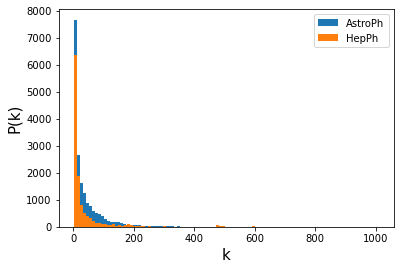

In [26]:
plt.hist(kkastroPh, bins = 100 ,label="AstroPh")
plt.hist(kkhepPh, bins = 100 ,label="HepPh")
plt.xlabel('k',size=15)
plt.ylabel('P(k)',size=15)
plt.legend()
plt.show()

En pasant en échelle logarithmique, on observe quelque chose de proche d'une droite décroissante et on retrouve l'observation précédente : la probabilité d'avoir un noeud de degré élevé est plus faible pour le réseau `AstroPh` que `HepPh` (le dernier point bleu est bien plus bas), l'écart-type est plus faible pour `AstroPh`. 

$\implies$ Les réseaux sont donc proches entre eux sauf pour les noeuds à plus haut degré.

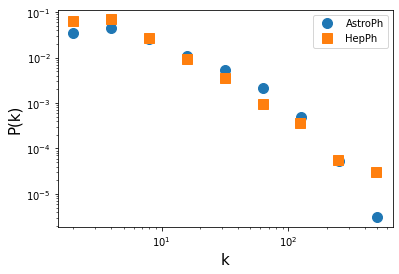

In [22]:
# a function for log binning for distributions
def logBinning(degreeList,nbin):
    kmin=min(degreeList)
    kmax=max(degreeList)
    logBins = np.logspace(np.log10(kmin), np.log10(kmax),num=nbin)
    logBinDensity, binedges = np.histogram(degreeList, bins=logBins, density=True)
    logBins = np.delete(logBins, -1)
    return logBinDensity, logBins
y,x=logBinning(np.array(kkastroPh),10)
plt.loglog(x,y,'o',label='AstroPh',markersize=10)
y,x=logBinning(np.array(kkhepPh),10)
plt.loglog(x,y,'s',label='HepPh',markersize=10)
plt.xlabel('k',size=15)
plt.ylabel('P(k)',size=15)
plt.legend()
plt.show()

## 3. Average clustering coefficient
On trace le *clustering spectrum* pour analyser le clustering coefficient.
Dans le réseau `astroPH` les noeuds qui ont un degré le plus élevé ont un clustering plus bas mais pour le réseau `hepPh` le clustering est proche du même niveau quelque soit le degré. 

- `astroPH` : dans ce réseau, les chercheurs qui ont le degré le plus élevé ont peut-être plus tendance à co-écrire avec des gens qu'ils ne connaissent pas forcément (effet "stars")
- `hepPh` : il n'y a pas cet effet, la probabilité que deux noeuds de même degré soient connectés ne dépend pas du degré. On y verra un peu plus clair avec la partie 4.

In [ ]:
ccastroPh=[nx.clustering(astroPh,u) for u in astroPh.nodes()]
cchepPh=[nx.clustering(hepPh,u) for u in hepPh.nodes()]

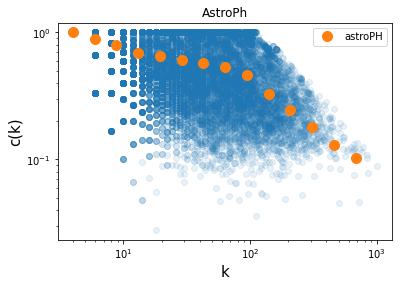

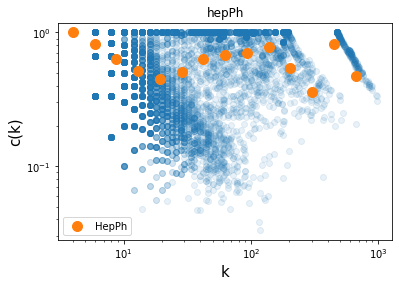

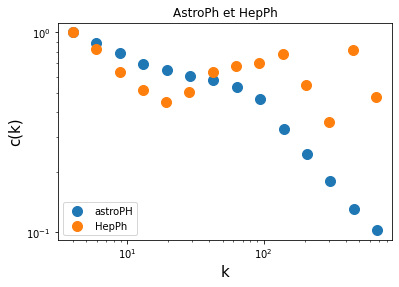

In [30]:
#For AstroPh
xx=[u for (u,v) in zip(kkastroPh,ccastroPh) if v>0]
yy=[v for (u,v) in zip(kkastroPh,ccastroPh) if v>0]
plt.loglog(xx,yy,'o',alpha=0.1) # On plot tous les points
loastroPhins=np.logspace(np.log2(np.min(xx)),np.log2(np.max(xx)),base=2,num=15)
# On fait une somme par classes de degrés échelle logarithmique
ybin1,xbin1,binnumber=scipy.stats.binned_statistic(xx,yy,statistic='mean',bins=loastroPhins)
plt.loglog(xbin1[:-1],ybin1,'o',label='astroPH',markersize=10)

plt.xlabel('k',size=15)
plt.ylabel('c(k)',size=15)
plt.title("AstroPh")
plt.show()

#For hepPh
xx=[u for (u,v) in zip(kkhepPh,cchepPh) if v>0]
yy=[v for (u,v) in zip(kkhepPh,cchepPh) if v>0]
plt.loglog(xx,yy,'o',alpha=0.1) # On plot tous les points
lohepPhins=np.logspace(np.log2(np.min(xx)),np.log2(np.max(xx)),base=2,num=15)
# On fait une somme par classes de degrés échelle logarithmique
ybin2,xbin2,binnumber=scipy.stats.binned_statistic(xx,yy,statistic='mean',bins=lohepPhins)
plt.loglog(xbin2[:-1],ybin2,'o',label='HepPh',markersize=10)

plt.xlabel('k',size=15)
plt.ylabel('c(k)',size=15)
plt.title("hepPh")
plt.show()

#For both
plt.loglog(xbin1[:-1],ybin1,'o',label='astroPH',markersize=10)
plt.loglog(xbin2[:-1],ybin2,'o',label='HepPh',markersize=10)
plt.xlabel('k',size=15)
plt.ylabel('c(k)',size=15)
plt.legend()
plt.title("AstroPh et HepPh")
plt.show()

## 4. Degree mixing

On est plutôt dans une situation *assortative mixing*, encore plus forte pour `hepPh` : les noeuds de degrés bas sont liés de préférence avec des noeuds de degrés bas et les noeuds de degrés élevés sont liés à des noeuds de degrés élevés.
Les chercheurs les plus "importants" ont donc tendance à écrire plus de papiers avec les chercheurs "importants", cet effet est encore plus élevé pour le réseaux de collaboration en physique des hautes énergies.

In [32]:
knnastroPh=[np.mean([astroPh.degree(v) for v in astroPh.neighbors(u)])  for u in astroPh.nodes()]
knnhepPh=[np.mean([hepPh.degree(v) for v in hepPh.neighbors(u)]) for u in hepPh.nodes()]

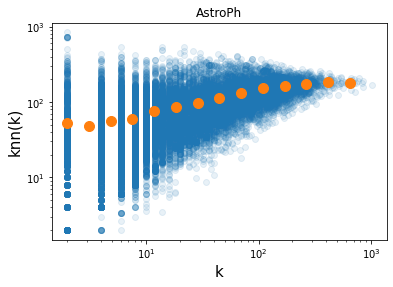

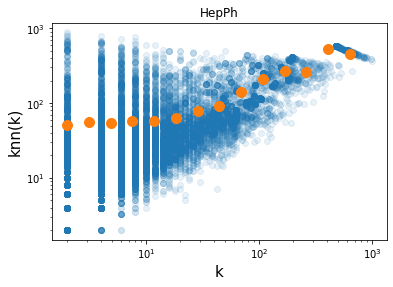

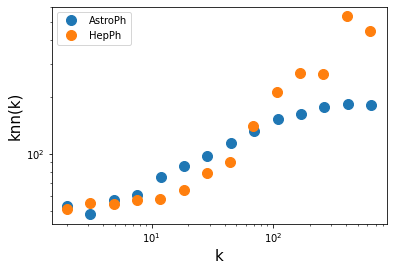

In [36]:
#For AstroPh
xx=[u for (u,v) in zip(kkastroPh,knnastroPh) if v>0]
yy=[v for (u,v) in zip(kkastroPh,knnastroPh) if v>0]
plt.loglog(xx,yy,'o',alpha=0.1)
loastroPhins=np.logspace(np.log2(np.min(xx)),np.log2(np.max(xx)),base=2,num=15)
#if I use np.linspace I will have linear bins
ybin1,xbin1,binnumber=scipy.stats.binned_statistic(xx,yy,statistic='mean',bins=loastroPhins)
plt.loglog(xbin1[:-1],ybin1,'o',label='AstroPh',markersize=10)

plt.xlabel('k',size=15)
plt.ylabel('knn(k)',size=15)
plt.title("AstroPh")
plt.show()

#For hepPh
xx=[u for (u,v) in zip(kkhepPh,knnhepPh) if v>0]
yy=[v for (u,v) in zip(kkhepPh,knnhepPh) if v>0]
plt.loglog(xx,yy,'o',alpha=0.1)
lohepPhins=np.logspace(np.log2(np.min(xx)),np.log2(np.max(xx)),base=2,num=15)
#if I use np.linspace I will have linear bins
ybin2,xbin2,binnumber=scipy.stats.binned_statistic(xx,yy,statistic='mean',bins=lohepPhins)
plt.loglog(xbin2[:-1],ybin2,'o',label='HepPh',markersize=10)

plt.xlabel('k',size=15)
plt.ylabel('knn(k)',size=15)
plt.title("HepPh")
plt.show()

plt.loglog(xbin1[:-1],ybin1,'o',label='AstroPh',markersize=10)
plt.loglog(xbin2[:-1],ybin2,'o',label='HepPh',markersize=10)
plt.xlabel('k',size=15)
plt.ylabel('knn(k)',size=15)
plt.title("AstroPh et HepPh")
plt.legend()
plt.show()

# Réseaux des échanges commerciaux, entre pays, de bananes et de voitures
## 1. Chargement des bases et quelques mesures

In [58]:
#import libraries
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats
import collections
from scipy.optimize import curve_fit
import pandas as pd
import random

In [59]:
import pandas as pd
dfbananas=pd.read_csv('data/bananasDB.csv',sep=',')
dfvehicles=pd.read_csv('data/vehiclesDB.csv',sep=',')
print(dfbananas.head())
dfvehicles.head()

           exp     imp       v
0  Afghanistan  France   3.203
1      Albania  Greece  26.597
2      Andorra  Canada   0.116
3       Angola  France   0.100
4       Angola   Japan   0.018


,exp,imp,v
0,Albania,France,8950.537
1,Albania,Greece,1487.509
2,Albania,Italy,14660.651
3,Albania,Senegal,1511.352
4,Algeria,Egypt,3411.627


On crée des graphes non dirigés :

In [75]:
dbananas=nx.from_pandas_edgelist(dfbananas,'exp','imp',['v'],create_using=nx.DiGraph())
bananas=nx.to_undirected(dbananas)
for (i,j) in bananas.edges():
    bananas[i][j]['weight']=0
    if (i,j) in dbananas.edges():
        bananas[i][j]['weight']+= dbananas[i][j]['v']
        bananas[j][i]['weight'] = bananas[i][j]['weight']
    if (j,i) in dbananas.edges():
        bananas[i][j]['weight']+= dbananas[j][i]['v']
        bananas[j][i]['weight'] = bananas[i][j]['weight']
dvehicles=nx.from_pandas_edgelist(dfvehicles,'exp','imp',['v'],create_using=nx.DiGraph())
vehicles=nx.to_undirected(dvehicles)
for (i,j) in vehicles.edges():
    vehicles[i][j]['weight']=0
    if (i,j) in dvehicles.edges():
        vehicles[i][j]['weight']+= dvehicles[i][j]['v']
        vehicles[j][i]['weight'] = vehicles[i][j]['weight']
    if (j,i) in dvehicles.edges():
        vehicles[i][j]['weight']+= dvehicles[j][i]['v']
        vehicles[j][i]['weight'] = vehicles[i][j]['weight']

## 2. Analyse robustesse avec des attaques
### 2.a Bananes

**Attaque aléatoire** : on plante la `seed` pour retrouver tout le temps les mêmes résultats.

In [80]:
random.seed(2021)

In [81]:
fList=np.linspace(0,1,20)
NtoRem=[int(i*bananas.number_of_nodes()) for i in fList]
print(NtoRem)
sfBan=[]
for nn in NtoRem[:-1]:
    thisbananas=bananas.copy() # recopie le bananasraph
    ll=random.sample(bananas.nodes(),nn) # SRS de ces noeuds
    thisbananas.remove_nodes_from(ll)
    # On prend la composante la plus bananasrande et on prend sa taille
    thisSf=len(max(sorted(nx.connected_components(thisbananas), key = len, reverse=True)))
    sfBan.append(thisSf/float(bananas.number_of_nodes()))

[0, 10, 21, 32, 42, 53, 64, 74, 85, 96, 106, 117, 128, 138, 149, 160, 170, 181, 192, 203]


**Attaque ciblée 1** : on enlève noeuds qui ont un degré le plus important.

In [82]:
hh=collections.Counter(dict(bananas.degree())).most_common()
orderedNodes=[u for (u,v) in hh] # on trie les noeuds selon le degré
print(orderedNodes[:10])
NtoRem=[int(i*bananas.number_of_nodes()) for i in fList]
sfAttBan1=[]
for nn in NtoRem[:-1]:
    thisbananas=bananas.copy()
    ll=orderedNodes[:nn] # on prend les premiers nn, on les enlève
    thisbananas.remove_nodes_from(ll)
    thisSf=len(max(sorted(nx.connected_components(thisbananas), key = len, reverse=True)))
    sfAttBan1.append(thisSf/float(bananas.number_of_nodes()))

['France', 'Netherlands', 'Germany', 'United Kingdom', 'Ecuador', 'Costa Rica', 'USA', 'Belgium', 'Spain', 'China']


**Attaque ciblée 2** : on enlève noeuds qui ont une force plus importante. La force d'un noeud est égale à la somme des points des liens auquels il est connecté :
$$
s_i=\sum_j w_{ij}
$$
Cela revient donc à calculer des degrés pondérés par la variable `weight` : on remplace `bananas.degree()` par `bananas.degree(weight="weight")`.
Vérification pour le noeud "France" :

In [83]:
print(bananas.degree('France', weight="weight"))
sum([x[2]['weight'] for x in list(bananas.edges("France", data = True))])

572577.0619999999


572577.0619999999

**NB** : les graphiques et l'analyse des attaques est faite à la fin du notebook.

In [84]:
hh=collections.Counter(dict(bananas.degree(weight="weight"))).most_common()
orderedNodes=[u for (u,v) in hh] # on trie les noeuds selon le degré
print(orderedNodes[:10])
#fList=np.linspace(0,1,20)
NtoRem=[int(i*bananas.number_of_nodes()) for i in fList]
sfAttBan2=[]
for nn in NtoRem[:-1]:
    thisbananas=bananas.copy()
    ll=orderedNodes[:nn] # on prend les premiers nn, on les enlève
    thisbananas.remove_nodes_from(ll)
    thisSf=len(max(sorted(nx.connected_components(thisbananas), key = len, reverse=True)))
    sfAttBan2.append(thisSf/float(bananas.number_of_nodes()))

['Ecuador', 'USA', 'Costa Rica', 'Belgium', 'Philippines', 'Germany', 'Colombia', 'Netherlands', 'Guatemala', 'Japan']


### 2.b Véhicules

**Attaque aléatoire**

In [85]:
NtoRem=[int(i*vehicles.number_of_nodes()) for i in fList]
print(NtoRem)
sfVeh=[]
for nn in NtoRem[:-1]:
    thisvehicles=vehicles.copy() # recopie le vehiclesraph
    ll=random.sample(vehicles.nodes(),nn) # SRS de ces noeuds
    thisvehicles.remove_nodes_from(ll)
    # On prend la composante la plus vehiclesrande et on prend sa taille
    thisSf=len(max(sorted(nx.connected_components(thisvehicles), key = len, reverse=True)))
    sfVeh.append(thisSf/float(vehicles.number_of_nodes()))

[0, 11, 22, 33, 44, 56, 67, 78, 89, 100, 112, 123, 134, 145, 156, 168, 179, 190, 201, 213]


**Attaque ciblée 1** : on enlève noeuds qui ont un degré le plus important.

In [86]:
hh=collections.Counter(dict(vehicles.degree())).most_common()
orderedNodes=[u for (u,v) in hh] # on trie les noeuds selon le degré
print(orderedNodes[:10])
NtoRem=[int(i*vehicles.number_of_nodes()) for i in fList]
sfAttVeh1=[]
for nn in NtoRem[:-1]:
    thisvehicles=vehicles.copy()
    ll=orderedNodes[:nn] # on prend les premiers nn, on les enlève
    thisvehicles.remove_nodes_from(ll)
    thisSf=len(max(sorted(nx.connected_components(thisvehicles), key = len, reverse=True)))
    sfAttVeh1.append(thisSf/float(vehicles.number_of_nodes()))

['USA', 'China', 'Germany', 'Japan', 'Rep. of Korea', 'United Kingdom', 'Netherlands', 'France', 'Belgium', 'Italy']


**Attaque ciblée 2** : on enlève noeuds qui ont une force plus importante. La force d'un noeud est égale à la somme des points.

In [87]:
hh=collections.Counter(dict(vehicles.degree(weight="weight"))).most_common()
orderedNodes=[u for (u,v) in hh] # on trie les noeuds selon le degré
print(orderedNodes[:10])
#fList=np.linspace(0,1,20)
NtoRem=[int(i*vehicles.number_of_nodes()) for i in fList]
sfAttVeh2=[]
for nn in NtoRem[:-1]:
    thisvehicles=vehicles.copy()
    ll=orderedNodes[:nn] # on prend les premiers nn, on les enlève
    thisvehicles.remove_nodes_from(ll)
    thisSf=len(max(sorted(nx.connected_components(thisvehicles), key = len, reverse=True)))
    sfAttVeh2.append(thisSf/float(vehicles.number_of_nodes()))

['USA', 'Germany', 'Japan', 'Mexico', 'China', 'United Kingdom', 'France', 'Canada', 'Spain', 'Italy']


### 2.c Analyse des graphiques

Les attaques sur le degré sont plus efficaces que les attaques sur la force pour le réseau des bananes.

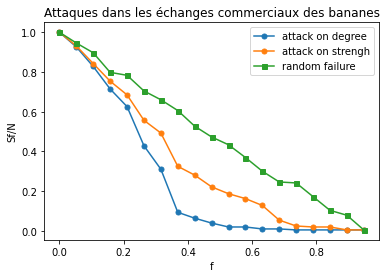

In [89]:
plt.plot(fList[:-1],sfAttBan1,'o-',markersize=5,label='attack on degree')
plt.plot(fList[:-1],sfAttBan2,'o-',markersize=5,label='attack on strengh')
plt.plot(fList[:-1],sfBan,'s-',markersize=5,label='random failure')
plt.xlabel('f')
plt.ylabel('Sf/N')
plt.legend()
plt.title("Attaques dans les échanges commerciaux des bananes")
plt.show()

Les attaques sont aussi efficaces que les attaques sur la force pour le réseau des véhicules.

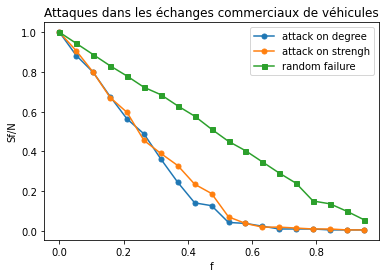

In [90]:
plt.plot(fList[:-1],sfAttVeh1,'o-',markersize=5,label='attack on degree')
plt.plot(fList[:-1],sfAttVeh2,'o-',markersize=5,label='attack on strengh')
plt.plot(fList[:-1],sfVeh,'s-',markersize=5,label='random failure')
plt.xlabel('f')
plt.ylabel('Sf/N')
plt.legend()
plt.title("Attaques dans les échanges commerciaux de véhicules")
plt.show()

Le réseau des bananes est plus sensible aux attaques que le réseau des véhicules : on peut donc penser qu'il y a plus de pays important commercialement pour la vente de bananes.

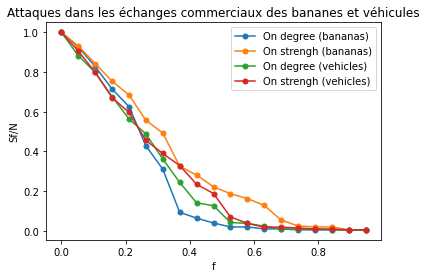

In [91]:
plt.plot(fList[:-1],sfAttBan1,'o-',markersize=5,label='On degree (bananas)')
plt.plot(fList[:-1],sfAttBan2,'o-',markersize=5,label='On strengh (bananas)')
plt.plot(fList[:-1],sfAttVeh1,'o-',markersize=5,label='On degree (vehicles)')
plt.plot(fList[:-1],sfAttVeh2,'o-',markersize=5,label='On strengh (vehicles)')
plt.xlabel('f')
plt.ylabel('Sf/N')
plt.legend()
plt.title("Attaques dans les échanges commerciaux des bananes et véhicules")
plt.show()

## Weighted spectrum
Il existe plusieurs façons de calculer un clustering coefficient pondéré, résumées par exemple dans cet article : http://jponnela.com/web_documents/a9.pdf. Nous allons en citer deux : celle demandée dans ce CC4 et celle implémentée dans networkx.
Notons $s_i$ la force d'un noeud $i$ et $k_i$ son degré.

- *Barrat .et al* (2004) ont proposé la méthode suivante :
$$
\widetilde C_{i,B} = \frac{1}{s_i(k_i-1)}\sum_{j,k} \frac{w_{ij} + w_{ik}}{2} a_{ij} a_{jk} a_{ik}
$$
Avec $a_{ij}=1$ s'il y a une arête entre $i$ et $j$ et 0 sinon.
- *Onnela .et al* (2003) ont proposé une autre formule, qui est celle implémentée dans networkx, basée sur le concept d'*intensité* d'un sous-graph (= moyenne géométrique des poids des arrêtes du sous-graph) :
$$
\widetilde C_{i,O} = \frac{1}{k_i(k_i-1)}\sum_{j,k} 
\left(\hat w_{ij} \hat w_{ik} \hat w_{jk}\right)^{1/3}
$$
où $\hat w_{ij}=w_{ij}/\max(w)$ (normalisation par le poids maximal).

Ces deux fonctions sont implémentées dans un autre package, `nggt`, que l'on peut installer avec la commande suivante :
```
!pip install --user nngt
```
Ensuite en utilisant la fonction `nngt.analysis.local_clustering` avec l'option `method = 'barrat'` on peut calculer le coefficient de clustering avec la méthode de *Barrat .et al*. Malheureusement l'installation ne marche pas chez moi.

In [67]:
import nngt
import nngt.generation as ng

ModuleNotFoundError: No module named 'nngt'

In [129]:
def nodes_connected(G, u, v):
    return u in G.neighbors(v)
def lw_clustering(G, i, weight = "weight"):
    a_ij=aik=1
    k_i = G.degree(i)
    s_i = G.degree(i, weight = "weight")
    sum_=[]
    for data_j in list(G.edges(i,data=True)):
        for data_k in list(G.edges(i,data=True)):
            j = data_j[1]
            w_ij = data_j[2]["weight"]
            k = data_k[1]
            w_ik = data_k[2]["weight"]
            # Rmq : si j=k alors a_jk = 0
            a_jk = nodes_connected(G,j,k)
            sum_.append( (w_ij + w_ik)/2 * a_jk * a_ij * aik)
    if k_i==1:
        lwc = 0
    else:
        lwc = (1 / (s_i * (k_i-1) ) )* sum(sum_)
    if lwc>1:
        print(i)
    
    return lwc

In [131]:
i = list(vehicles.nodes('France'))[1]
G = vehicles
list(G.edges(i,data=True))
lw_clustering(G,vehicles.nodes('Algeria'))

TypeError: unsupported operand type(s) for -: 'DegreeView' and 'int'

In [130]:
kk=[vehicles.degree(u) for u in vehicles.nodes()]
cc=[nx.clustering(vehicles,u) for u in vehicles.nodes()]
cc_w = [nx.clustering(vehicles,u,weight="weight") for u in vehicles.nodes()]
cc_w_barrat=[lw_clustering(vehicles,u) for u in vehicles.nodes()]

Algeria
Bangladesh
Fiji
Mongolia
New Caledonia
Papua New Guinea
Solomon Isds
Timor-Leste
Vanuatu
Yemen
Cuba
Syria
Cabo Verde
Chad
Comoros
Equatorial Guinea
French Polynesia
Gambia
Guyana
Mauritania
CuraÁao
Haiti
Saint Maarten
Antigua and Barbuda
Barbados
Br. Virgin Isds
Guinea-Bissau
Malawi
Maldives
Seychelles
South Sudan
Trinidad and Tobago
Dominica
Saint Kitts and Nevis


Mais il y a vraisemblablement un problème car le coefficient devrait être entre 0 et 1...

In [126]:
print(min(cc_w_barrat))
print(max(cc_w_barrat))
print(sum(cc_w_barrat)/len(cc_w_barrat))

0
1.147096789687662
0.7879819800409226


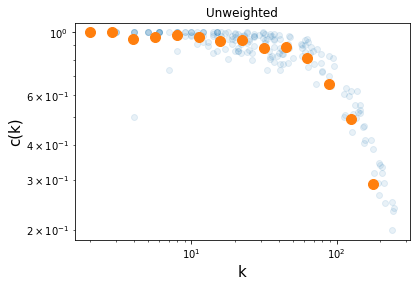

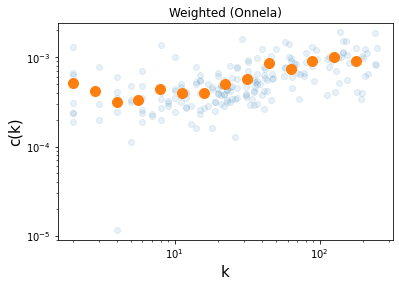

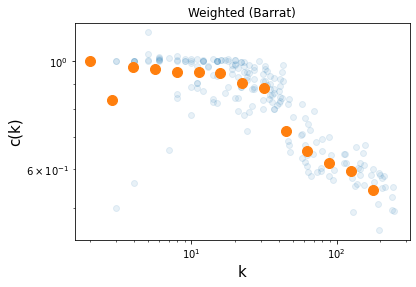

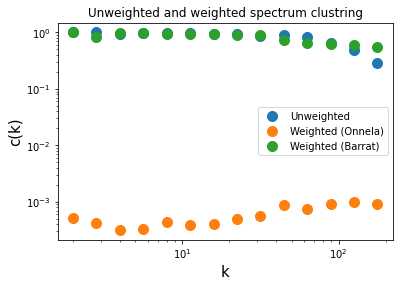

In [134]:
#For AstroPh
xx=[u for (u,v) in zip(kk,cc) if v>0]
yy=[v for (u,v) in zip(kk,cc) if v>0]
plt.loglog(xx,yy,'o',alpha=0.1) # On plot tous les points
lo=np.logspace(np.log2(np.min(xx)),np.log2(np.max(xx)),base=2,num=15)
# On fait une somme par classes de degrés échelle logarithmique
ybin1,xbin1,binnumber=scipy.stats.binned_statistic(xx,yy,statistic='mean',bins=lo)
plt.loglog(xbin1[:-1],ybin1,'o',label='Unweighted',markersize=10)

plt.xlabel('k',size=15)
plt.ylabel('c(k)',size=15)
plt.title("Unweighted")
plt.show()

#For hepPh
xx=[u for (u,v) in zip(kk,cc_w) if v>0]
yy=[v for (u,v) in zip(kk,cc_w) if v>0]
plt.loglog(xx,yy,'o',alpha=0.1) # On plot tous les points
lo=np.logspace(np.log2(np.min(xx)),np.log2(np.max(xx)),base=2,num=15)
# On fait une somme par classes de degrés échelle logarithmique
ybin2,xbin2,binnumber=scipy.stats.binned_statistic(xx,yy,statistic='mean',bins=lo)
plt.loglog(xbin2[:-1],ybin2,'o',label='Weighted (Onnela)',markersize=10)

plt.xlabel('k',size=15)
plt.ylabel('c(k)',size=15)
plt.title("Weighted (Onnela)")
plt.show()

xx=[u for (u,v) in zip(kk,cc_w_barrat) if v>0]
yy=[v for (u,v) in zip(kk,cc_w_barrat) if v>0]
plt.loglog(xx,yy,'o',alpha=0.1) # On plot tous les points
lo=np.logspace(np.log2(np.min(xx)),np.log2(np.max(xx)),base=2,num=15)
# On fait une somme par classes de degrés échelle logarithmique
ybin3,xbin3,binnumber=scipy.stats.binned_statistic(xx,yy,statistic='mean',bins=lo)
plt.loglog(xbin3[:-1],ybin3,'o',label='Weighted (Barrat)',markersize=10)

plt.xlabel('k',size=15)
plt.ylabel('c(k)',size=15)
plt.title("Weighted (Barrat)")
plt.show()



#For both
plt.loglog(xbin1[:-1],ybin1,'o',label='Unweighted',markersize=10)
plt.loglog(xbin2[:-1],ybin2,'o',label='Weighted (Onnela)',markersize=10)
plt.loglog(xbin3[:-1],ybin3,'o',label='Weighted (Barrat)',markersize=10)
plt.xlabel('k',size=15)
plt.ylabel('c(k)',size=15)
plt.legend()
plt.title("Unweighted and weighted spectrum clustring")
plt.show()